# 1. 옛날 버전


In [ ]:
! pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

In [ ]:
# 훈련, 검증, 테스트셋 분류
#final = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/final.csv', encoding='cp949').drop('yyyymmdd', axis=1)
final = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/final_ver2.csv', encoding='cp949')#.drop('yyyymmdd', axis=1)
df = final[final['year'] != 2016]
train = df[df['year'] != 2015]
val = df[df['year'] == 2015]
test = final[final['year'] == 2016].drop('frequency', axis=1)

X_train = train.drop('frequency', axis=1)
y_train = train['frequency']
X_val = val.drop('frequency', axis=1)
y_val = val['frequency']

# 최종 증감분 계산 
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

# K-Fold 
def kfold(model, tr):
    cv_accuracy = []
    cv = KFold(n_splits = 5)
    n_iter = 0

    for t,v in cv.split(tr, tr['frequency']):
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y)
        score = RMSE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45224 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48513 missing from current font.
  font.set_

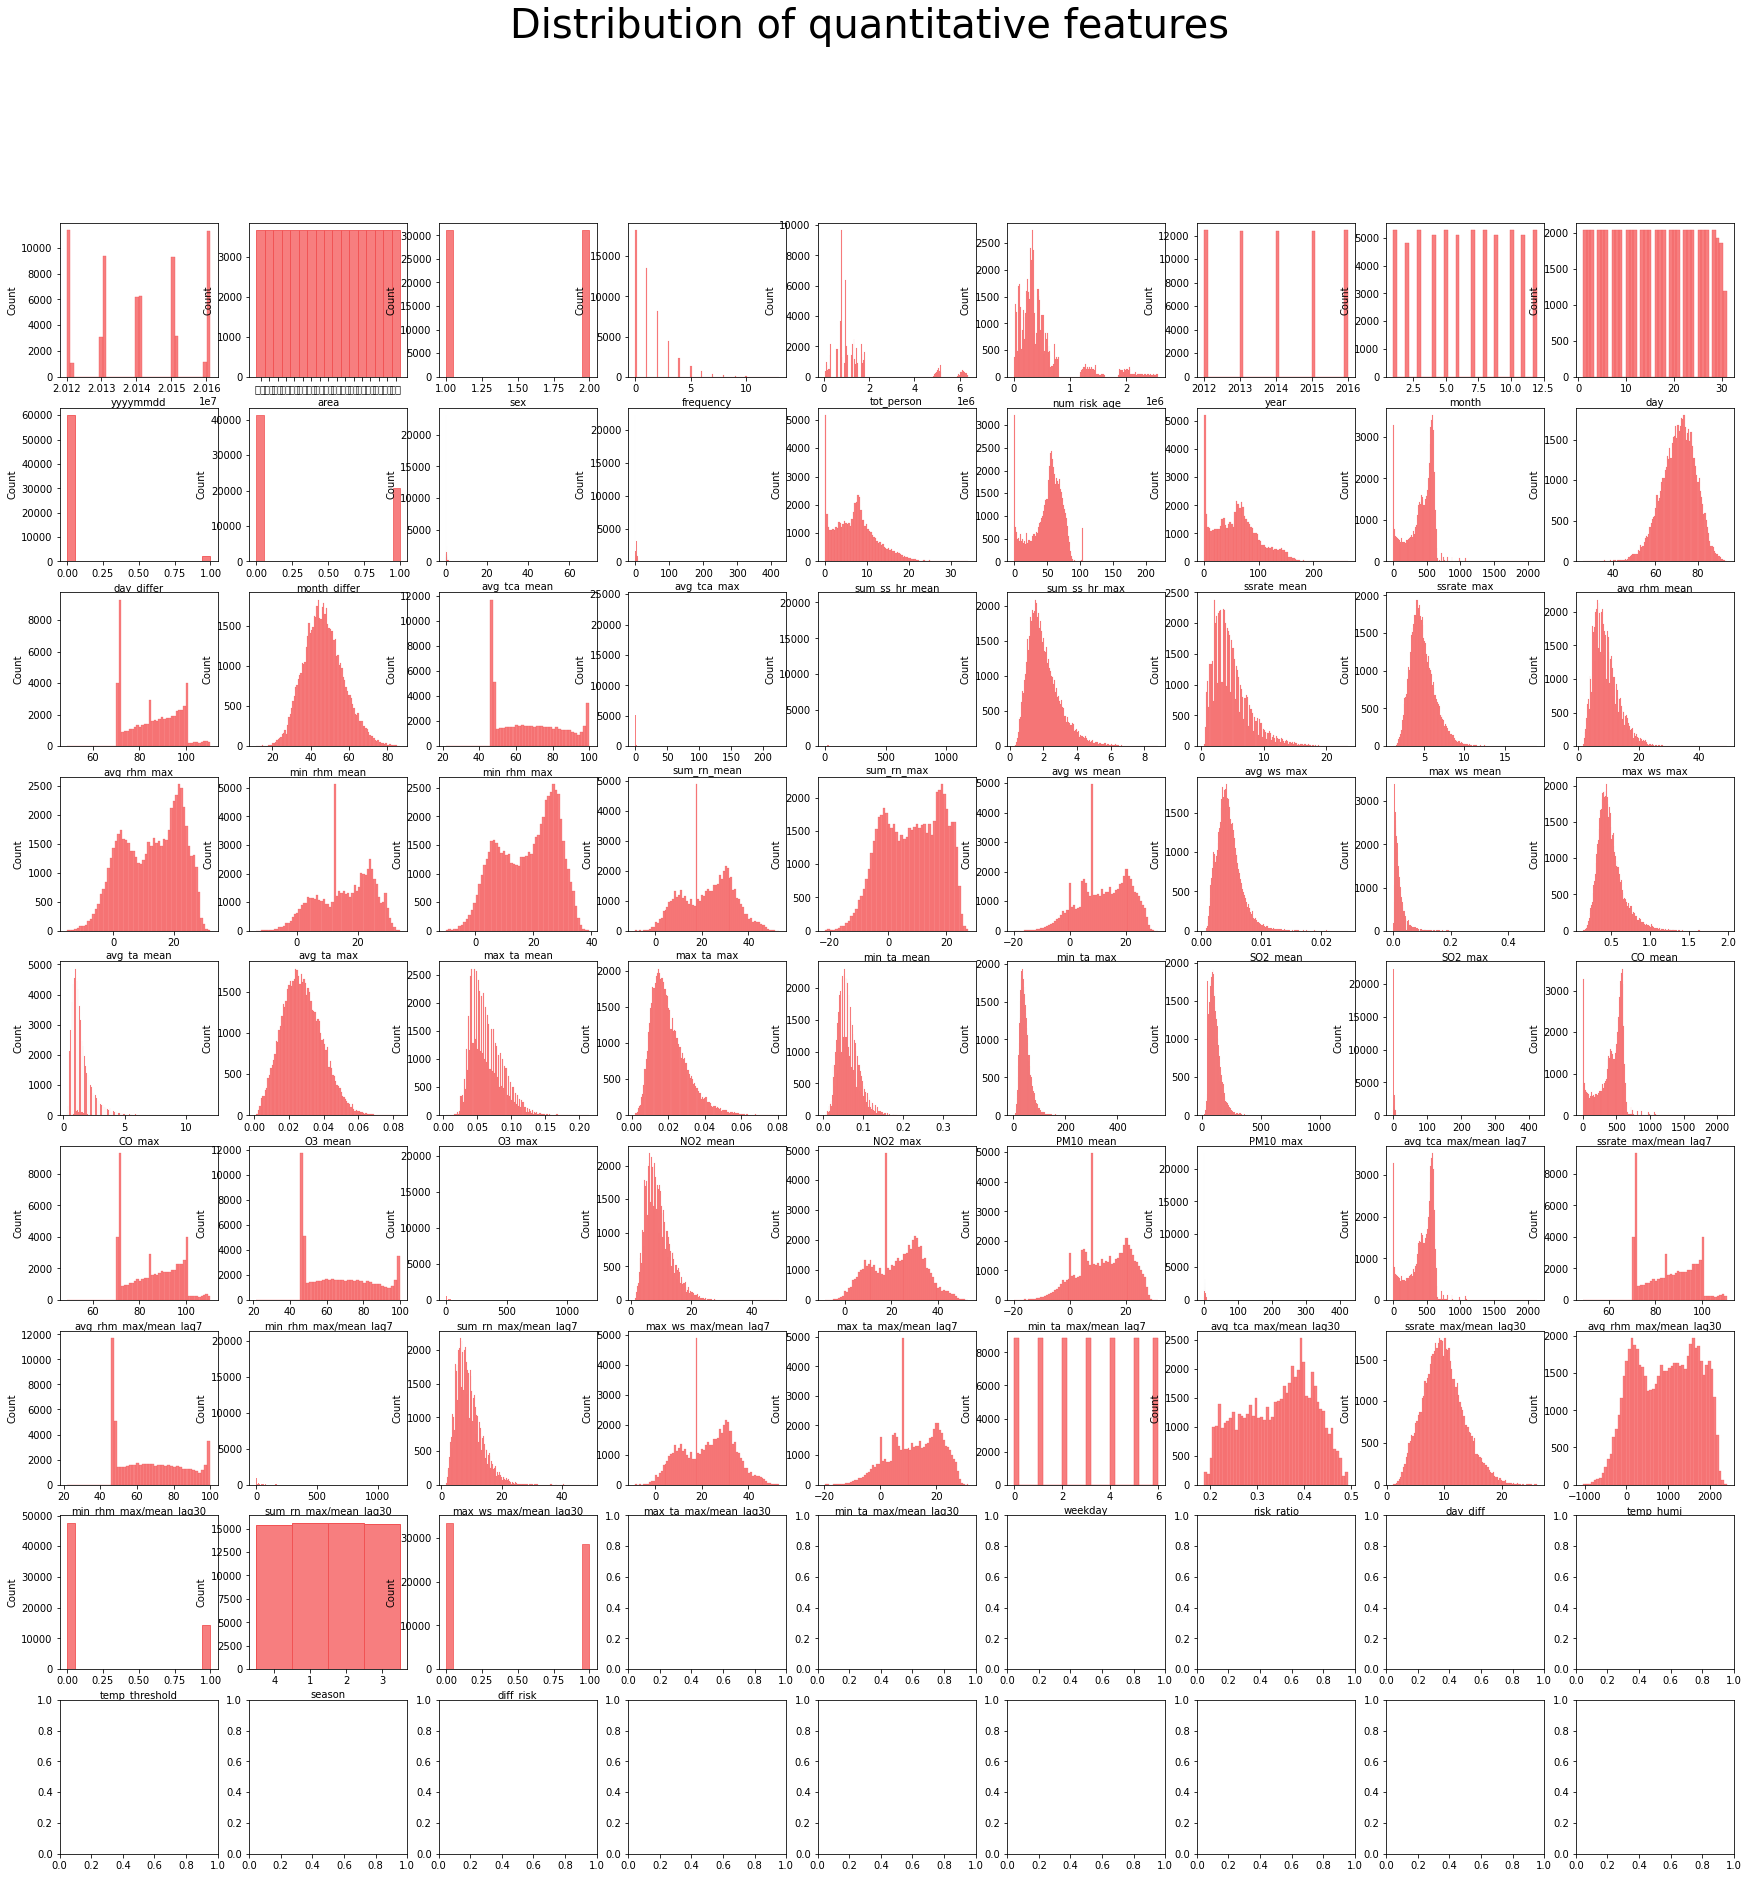

In [ ]:
import seaborn as sns 
fig, axes = plt.subplots(9, 9, figsize=(30, 30))
fig.suptitle('Distribution of quantitative features', fontsize=40)

for ax,feature in zip(axes.flatten(), final.columns):
    sns.histplot(data = final, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

In [ ]:
f,ax = plt.subplots(figsize=(25,25))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

In [ ]:
dates = pd.to_datetime(df['yyyymmdd'], format='%Y%m%d').dt
df['weekday']= dates.weekday

In [ ]:
df['risk_ratio'] = df['num_risk_age'] / df['tot_person']

# 2. 모델링

In [ ]:
! pip install catboost
! pip install optuna

In [ ]:
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
import random
random.seed(42)
np.random.seed(42)
# 모델 평가 지표 
def RMSE(true, pred):
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

def check_missing_col(dataframe):
    missing_col = []
    for col in dataframe.columns:
        missing_values = sum(dataframe[col].isna())
        is_missing = True if missing_values >= 1 else False
        if is_missing:
            print(f'결측치가 있는 컬럼은: {col} 입니다')
            print(f'해당 컬럼에 총 {missing_values} 개의 결측치가 존재합니다.')
            missing_col.append([col, dataframe[col].dtype])
    if missing_col == []:
        print('결측치가 존재하지 않습니다')
    return missing_col

submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')
final_back = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/final_back.csv')
final_back = final_back.sort_values(['yyyymmdd', 'sex', 'area']).reset_index(drop=True)

In [ ]:
f,ax = plt.subplots(figsize=(30, 30))
dff = final[['A03_t1_max', 'A03_t2_max', 'A03_t3_max','A03_t1_mean', 'A03_t2_mean', 'A03_t3_mean','A04_t1_max' ,'A04_t2_max',
   'A04_t3_max','A04_t1_mean', 'A04_t2_mean', 'A04_t3_mean','A05_t1_max','A05_t2_max','A05_t3_max','A06_t1_max', 
   'A06_t2_max', 'A06_t3_max','A07_t2_max','A05_t1_mean', 'A05_t2_mean','A05_t3_mean','A06_t1_mean', 'A06_t2_mean', 'A06_t3_mean','A07_t2_mean', ]]
sns.heatmap(dff.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)

In [118]:
dff['new'] = 100 * dff['frequency'] / dff['num_risk_age']
dff.groupby('area')['new'].sum().sort_values(ascending=False)

area
전남    1.172622
전북    1.113941
경남    1.095154
경북    1.087678
충북    1.077061
광주    1.064588
강원    1.052484
대전    0.904546
울산    0.888911
충남    0.882560
대구    0.850641
제주    0.823131
부산    0.809457
경기    0.794558
인천    0.740382
서울    0.655623
세종    0.395745
Name: new, dtype: float64

## 1) CatBoostRegressor

In [ ]:
final = dff.copy()

# 새로운 변수 생성 
final['temp'] = final[['3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21']].mean(axis=1)
final['humi'] = final[['습도_mean_9', '습도_mean_15', '습도_mean_21']].mean(axis=1)
final['temp_high'] = final[['일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21']].max(axis=1)
final['temp_low'] = final[['일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21']].min(axis=1)
final['wind'] = final[['풍속_mean_9','풍속_mean_15', '풍속_mean_21']].mean(axis=1)
final['rain'] = final[['강수량_mean_9','강수량_mean_15', '강수량_mean_21']].mean(axis=1)
final['snow'] = final[['적설_mean_9', '적설_mean_15', '적설_mean_21']].mean(axis=1)

final['A03'] = (final['A03_t1_mean'] + final['A03_t2_mean'] + final['A03_t3_mean']) / 3
final['A04'] = (final['A04_t1_mean'] + final['A04_t2_mean'] + final['A04_t3_mean']) / 3
final['A05'] = (final['A05_t1_mean'] + final['A05_t2_mean'] + final['A05_t3_mean']) / 3
final['A06'] = (final['A06_t1_mean'] + final['A06_t2_mean'] + final['A06_t3_mean']) / 3

dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['일최고기온_mean_15'] - final['일최저기온_mean_9']     # 일교차 
#final['temp_humi'] = final['humi'] * final['일최저기온_mean_9']   # 습도 * 기온
# https://www.karger.com/Article/Fulltext/505122

final['temp_threshold'] = np.where((final['일최저기온_mean_9'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070
conditionlist = [    
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified').astype('int64')  # 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 
final['capital_area'] = np.where((final['area'].isin(['서울', '경기'])), 1, 0)  # 서울, 경기 여부 

# 월 평균 환자 수 의 평균값보다 많은면 risk_month = 1 ,아니면 risk_month = 0
final_cpy = final.copy()
final_cpy = final_cpy.groupby(['month'])[final_cpy.columns].mean()
mean_sick = final_cpy['frequency'].mean()
for year in range(2012,2016+1):
  for month in range(1,12+1):
    if (final.loc[(final['year']==year) & (final['month']==month),'frequency'].mean()) >= mean_sick:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 1
    else:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 0
del final_cpy

'''
final['wind_ta_1'] = final['wind'] * final['temp']
final['wind_ta_2'] = final['wind'] * final['temp_high']   # 풍속 * 온도 
final['wind_ta_3'] = final['wind'] * final['temp_low']
'''

# 지연효과 반영 
def add_lag_feature(dat, lag = None):
    cols = [
        'temp', 'wind', 'rain', 'snow',
        'A03', 'A04', 'A05', 'A06', 'PM10_mean', 
       # 'SO2_mean','CO_mean', 'O3_mean', 'NO2_mean'    
            ] 
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, closed='left').mean().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}_lag{lag}'] = lag_mean[col]
    return dat
            
add_lag_feature(final, 3)

# 2012년 초 결측치 보간 
'''
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, imputation_order='roman',random_state=42)
df1 = final.drop(final.columns[0:11], axis=1)
df2 = final[final.columns[0:11]]
X = pd.DataFrame(imp.fit_transform(df1), columns = final.columns[11:])
final = pd.concat([df2, X], axis=1)
'''
# area 변수 라벨 인코딩 
cat_features = ['area']
for i in enumerate(cat_features):
    ca = i[1]
    encoder = LabelEncoder()
    encoder.fit(final[ca])
    final[ca] = encoder.transform(final[ca])

# 예상 증가 비율 
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

final = final.drop(['num_risk_age', 'tot_person',
                    # 'SO2_mean',
                    # 'CO_mean', 
                    # 'O3_mean', 
                    # 'NO2_mean',
                    # 'PM10_mean', 
                     
                    #  'A03_t1_max', 'A03_t2_max', 'A03_t3_max',
                    #  #'A03_t1_mean', 'A03_t2_mean', 'A03_t3_mean',
                    #  'A04_t1_max' ,'A04_t2_max','A04_t3_max',
                    #  #'A04_t1_mean', 'A04_t2_mean', 'A04_t3_mean',

                    #  'A05_t1_max','A05_t2_max','A05_t3_max',
                    #  'A06_t1_max', 'A06_t2_max', 'A06_t3_max',
                    #  'A07_t2_max',

                    #  #'A05_t1_mean', 'A05_t2_mean','A05_t3_mean',
                    #  #'A06_t1_mean', 'A06_t2_mean', 'A06_t3_mean',
                    #  'A07_t2_mean',
                    
                    '3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21',
                    '습도_mean_9', '습도_mean_15', '습도_mean_21', 
                    '일최고기온_mean_9','일최고기온_mean_15', '일최고기온_mean_21', 
                    '일최저기온_mean_9','일최저기온_mean_15', '일최저기온_mean_21', 
                    '풍속_mean_9','풍속_mean_15', '풍속_mean_21', 
                    '강수량_mean_9','강수량_mean_15', '강수량_mean_21', 
                    '적설_mean_9', '적설_mean_15', '적설_mean_21',

                    'A03_t1_mean', 'A03_t1_max', 'A03_t2_mean', 'A03_t2_max', 'A03_t3_mean', 'A03_t3_max',
                    'A04_t1_mean', 'A04_t1_max', 'A04_t2_mean', 'A04_t2_max', 'A04_t3_mean', 'A04_t3_max', 
                    'A05_t1_mean', 'A05_t1_max', 'A05_t2_mean', 'A05_t2_max', 'A05_t3_mean', 'A05_t3_max', 
                    'A06_t1_mean', 'A06_t1_max', 'A06_t2_mean', 'A06_t2_max', 'A06_t3_mean', 'A06_t3_max',
                    'A07_t2_mean', 'A07_t2_max', 

                   # 'weekday','risk_ratio', 'day_diff', 'temp_threshold', 'season', 'diff_risk', 'risk_month', 
                    ], axis=1)

# 경기, 경남, 경북, 서울 지역 제외 데이터 생성 
idx = final[final['area'].isin([1,2,3,8])].index
data_1 = final.drop(idx)

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
X = pd.DataFrame(scaled_X, columns=X.columns)

#따로따로 모델 용 
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
CAT = CatBoostRegressor(verbose=2, random_state=42, one_hot_max_size = 17, max_depth = 5)
CAT.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds = 50, use_best_model = True)
plotImp(CAT, X)

In [ ]:
# 학습함수 정의 
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
def objective(trial: Trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 1.5, step=0.05),
        'max_bin': trial.suggest_int('max_bin', 200, 500, step=20),   
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100, step=5),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.4, 1.0, step=0.1),
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter'])
    }
    model = CatBoostRegressor(**param, one_hot_max_size = 17, loss_function = 'RMSE', random_state=42)
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], early_stopping_rounds=50, verbose=False)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='CatBoostRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=300)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
# 예측치 생성 및 제출
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

CAT = CatBoostRegressor(**study.best_trial.params, random_state=42, one_hot_max_size = 17, loss_function = 'RMSE', n_estimators=500)
CAT.fit(X, y)

# 경기, 경남, 경북, 서울 지역 제외 데이터 학습 및 예측
def fitting(data):
    train = data[data['year'] != 2016].drop('yyyymmdd', axis=1)
    test = data[data['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

    X = train.drop('frequency', axis=1)
    y = train['frequency']

    CAT = CatBoostRegressor(**study.best_trial.params, verbose=2, random_state=42, one_hot_max_size = 17, n_estimators=500)
    CAT.fit(X,y)
    pred = CAT.predict(test) * rate

    return pred
pred_1 = fitting(data_1)

# 원래 모델 예측치 생성
CAT_pred = CAT.predict(test)
submit['frequency'] = CAT_pred * rate

# 경기, 경남, 경북, 서울 이외 지역 예측치 덮어쓰기
idx = submit[submit['area'].isin(['경기', '경남', '경북', '서울']) == False].index
submit.loc[idx, 'frequency'] = pred_1

CAT_predict = submit['frequency'].copy()
#submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

In [ ]:
# cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk']
CAT = CatBoostRegressor(verbose=1, random_seed=42, one_hot_max_size = 17, cat_features=['area', 'year', 'month', 'day', 'weekday', 'temp_threshold', 'diff_risk'])
# K-Fold 
def kfold(model, tr, num):
    cv_accuracy = []
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0

    for t,v in cv.split(tr, tr['frequency']): 
        train_cv = tr.iloc[t]
        val_cv = tr.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model.fit(X, y, eval_set = [(val_X, val_y)], early_stopping_rounds=50, verbose=False, use_best_model = True)
        score = RMSE(val_y, model.predict(val_X))
        print(f'{n_iter+1} rmse ======> {score}')

        cv_accuracy.append(score)
        n_iter += 1
    
    return np.mean(cv_accuracy)
kfold(CAT, train, 10)

### predict 10개 평균내기

In [ ]:
# 최종 예측치 생성 ==> 그냥 full로 예측하고 끝내는 거랑 이거랑 비교해서 제출(stacking이 아닌 단순 집계로 앙상블 할 경우의 얘기)
#CAT = CatBoostRegressor(**study.Best_trial)
CAT = CatBoostRegressor(verbose=1, random_seed=42, one_hot_max_size = 17, cat_features=['area', 'sex', 'year', 'month', 'day', 'day_differ', 'month_differ', 'weekday', 'temp_threshold', 'season', 'diff_risk'])
def kfold_predict(model, train, test, num):
    preds = np.zeros(test.shape[0])
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0
    rmse = []

    for t,v in cv.split(train, train['frequency']):#, groups=train['month']
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']
    
        model.fit(X, y, eval_set = [(val_X, val_y)],
                  early_stopping_rounds=50, verbose=False, use_best_model = True)
        
        preds += model.predict(test) / cv.n_splits

        rmse.append(RMSE(val_y, model.predict(val_X)))
        print(f'fold: {n_iter+1} ======> rmse : {rmse[n_iter]}')
        n_iter += 1
    print(f'total_mean ======> rmse : {np.mean(rmse)}')
    
    return preds
CAT_predict = kfold_predict(CAT, train, test, 10)

fold: 1 ======> rmse : 1.2184381234356423
fold: 2 ======> rmse : 1.2101360266220043
fold: 3 ======> rmse : 1.200506654822679
fold: 4 ======> rmse : 1.2312326307577712
fold: 5 ======> rmse : 1.2166831528377293
fold: 6 ======> rmse : 1.2290369596595807
fold: 7 ======> rmse : 1.2114330374602496
fold: 8 ======> rmse : 1.1936029567564164
fold: 9 ======> rmse : 1.2091009254767697
fold: 10 ======> rmse : 1.1957263771413928
total_mean ======> rmse : 1.2115896844970235


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')    
submit['frequency'] = CAT_predict * rate
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/220139.csv', encoding='cp949', index=False)

## 2) LGBM

### 시각화

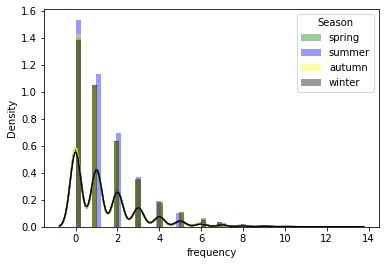

In [ ]:
sns.distplot(final[final['season'] == 1]["frequency"], color="green", label="spring")
sns.distplot(final[final['season'] == 2]["frequency"], color="blue", label="summer")
sns.distplot(final[final['season'] == 3]["frequency"], color="yellow", label="autumn")
sns.distplot(final[final['season'] == 4]["frequency"], color="black", label="winter")
plt.legend(title="Season")
plt.show()

In [ ]:
# 1. 범주형 변수 시각화
fig, axes = plt.subplots(5,3, figsize=(20,15))
fig.suptitle('Distribution of customers per category', fontsize=40)
categorical = ['area', 'sex','year', 'month', 'day', 'day_differ', 'month_differ', 'weekday', 'risk_ratio', 'day_diff', 'temp_threshold', 'season','diff_risk', 'risk_month', 'capital_area']
for ax, feature in zip(axes.flatten(), categorical):
    sns.countplot(data = train, x = feature, ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4361 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4469 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4352 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4449 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4523 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 4363 missing from current font.
  font.set_text(s

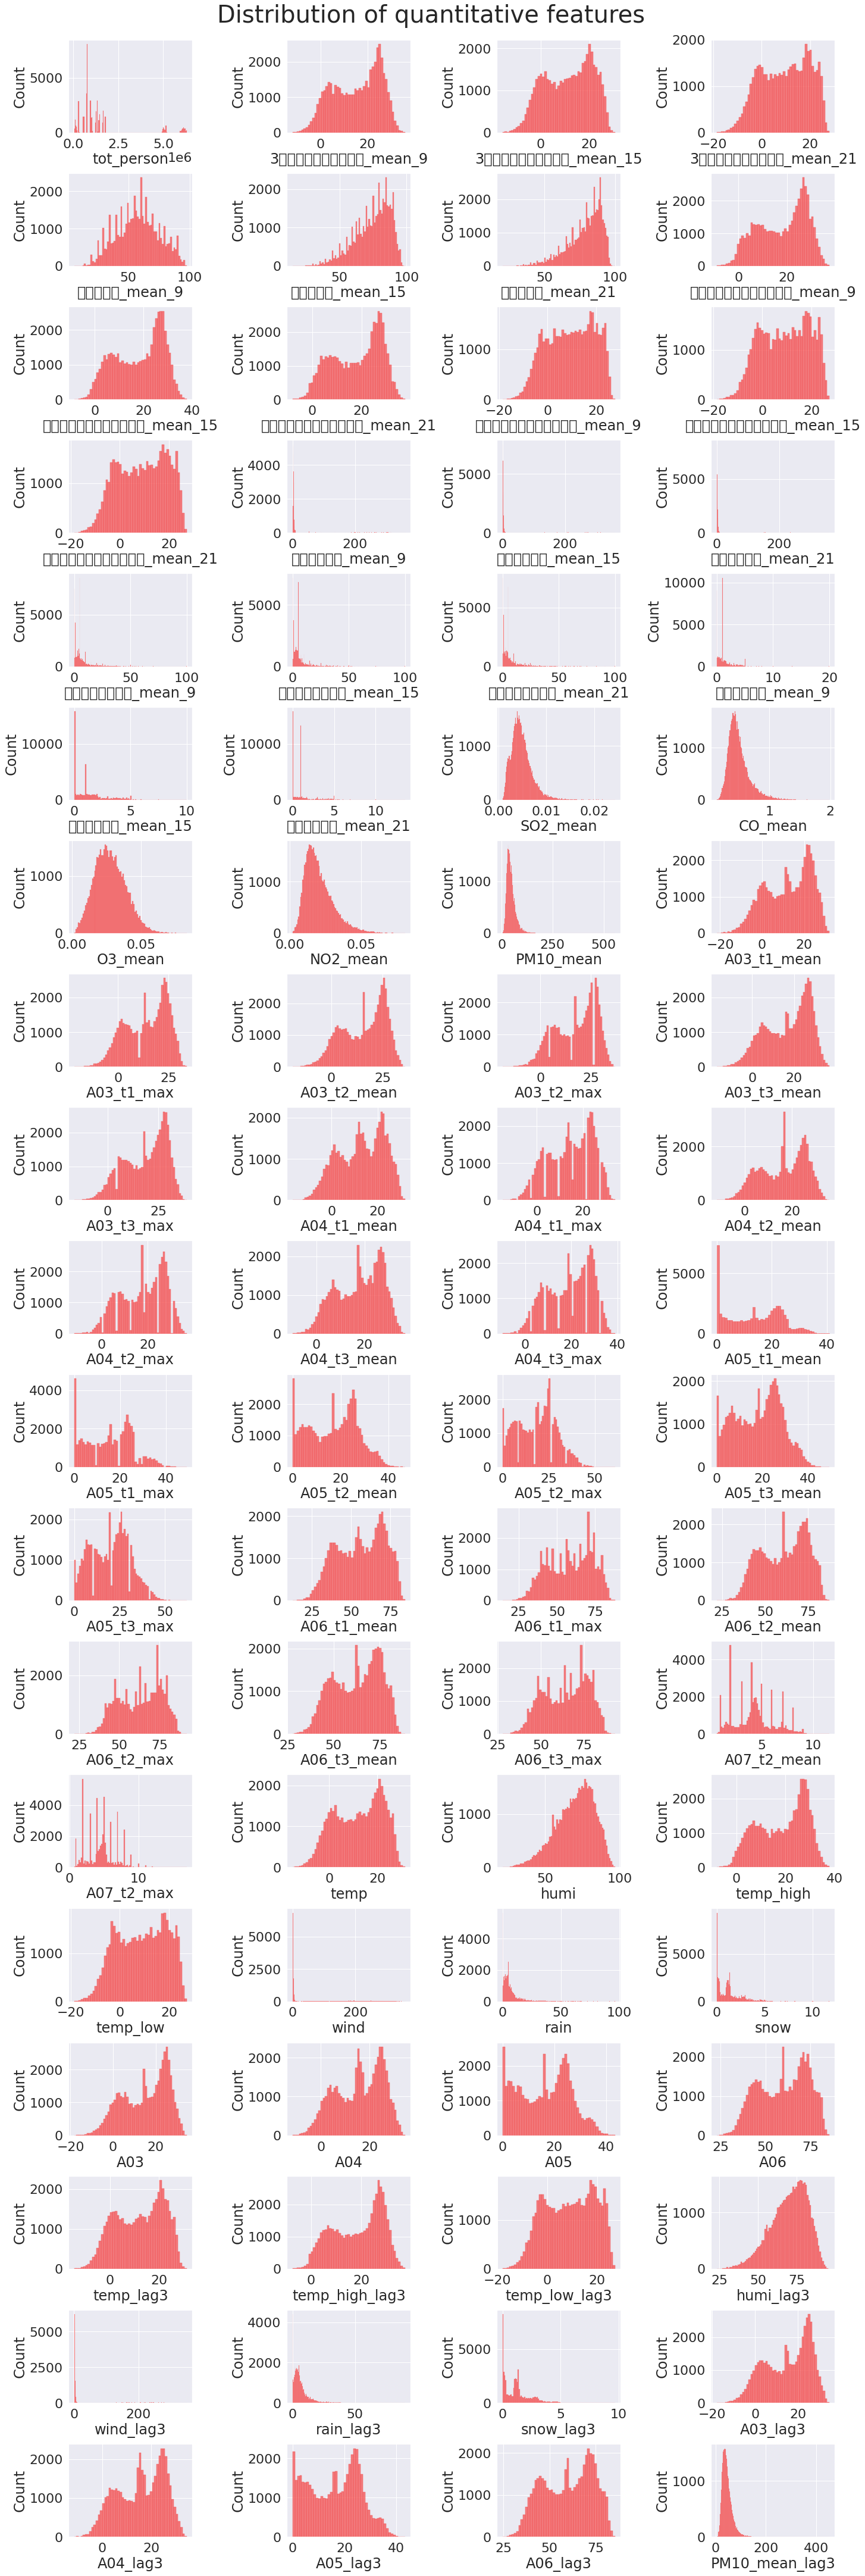

In [ ]:
# 2. 수치형 변수 시각화 
fig, axes = plt.subplots(19, 4, figsize=(20, 60),constrained_layout=True)
fig.suptitle('Distribution of quantitative features', fontsize=40)
#plt.tight_layout()

quantitative = ['tot_person', '3시간기온_mean_9', '3시간기온_mean_15',
       '3시간기온_mean_21', '습도_mean_9', '습도_mean_15', '습도_mean_21',
       '일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21',
       '일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21',
       '풍속_mean_9', '풍속_mean_15', '풍속_mean_21', '강수량_mean_9',
       '강수량_mean_15', '강수량_mean_21', '적설_mean_9',
       '적설_mean_15', '적설_mean_21', 'SO2_mean', 'CO_mean', 'O3_mean',
       'NO2_mean', 'PM10_mean', 'A03_t1_mean', 'A03_t1_max', 'A03_t2_mean',
       'A03_t2_max', 'A03_t3_mean', 'A03_t3_max', 'A04_t1_mean', 'A04_t1_max',
       'A04_t2_mean', 'A04_t2_max', 'A04_t3_mean', 'A04_t3_max', 'A05_t1_mean',
       'A05_t1_max', 'A05_t2_mean', 'A05_t2_max', 'A05_t3_mean', 'A05_t3_max',
       'A06_t1_mean', 'A06_t1_max', 'A06_t2_mean', 'A06_t2_max', 'A06_t3_mean',
       'A06_t3_max', 'A07_t2_mean', 'A07_t2_max', 'temp', 'humi', 'temp_high',
       'temp_low', 'wind', 'rain', 'snow', 'A03', 'A04', 'A05', 'A06', 'temp_lag3',
       'temp_high_lag3', 'temp_low_lag3', 'humi_lag3', 'wind_lag3',
       'rain_lag3', 'snow_lag3', 'A03_lag3', 'A04_lag3', 'A05_lag3',
       'A06_lag3', 'PM10_mean_lag3']
for ax,feature in zip(axes.flatten(),quantitative):
    sns.histplot(data = train, x = feature, ax=ax, color='#f55354', edgecolor='#f15354')
plt.show()

### 모델

In [108]:
final = final_back.copy()
dates = pd.to_datetime(final.yyyymmdd, format='%Y%m%d').dt

# 새로운 변수 생성 
final['year'] = dates.year
final['month'] = dates.month
final['day'] = dates.day
final['day_differ'] = [1 if i == 1 else 0 for i in final['day']]
final['month_differ'] = [1 if i in [5,6,8,9] else 0 for i in final['month']]

final['temp'] = final[['3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21']].mean(axis=1)
final['humi'] = final[['습도_mean_9', '습도_mean_15', '습도_mean_21']].mean(axis=1)
final['temp_high'] = final[['일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21']].max(axis=1)
final['temp_low'] = final[['일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21']].min(axis=1)
final['wind'] = final[['풍속_mean_9','풍속_mean_15', '풍속_mean_21']].mean(axis=1)
final['rain'] = final[['강수량_mean_9','강수량_mean_15', '강수량_mean_21']].mean(axis=1)
final['snow'] = final[['적설_mean_9', '적설_mean_15', '적설_mean_21']].mean(axis=1)

final['A03'] = (final['A03_t1'] + final['A03_t2'] + final['A03_t3']) / 3
final['A04'] = (final['A04_t1'] + final['A04_t2'] + final['A04_t3']) / 3
final['A05'] = (final['A05_t1'] + final['A05_t2'] + final['A05_t3']) / 3
final['A06'] = (final['A06_t1'] + final['A06_t2'] + final['A06_t3']) / 3

dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['일최고기온_mean_15'] - final['일최저기온_mean_9']     # 일교차 
#final['temp_humi'] = final['humi'] * final['일최저기온_mean_9']   # 습도 * 기온
# https://www.karger.com/Article/Fulltext/505122

final['temp_threshold'] = np.where((final['일최저기온_mean_9'] < -2.5), 1, 0)  # 뇌졸중 영향 온도 threshhold
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070
conditionlist = [    
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified').astype('int64')  # 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 
final['capital_area'] = np.where((final['area'].isin(['서울', '경기'])), 1, 0)  # 서울, 경기 여부 

# 월 평균 환자 수 의 평균값보다 많은면 risk_month = 1 ,아니면 risk_month = 0
final_cpy = final.copy()
final_cpy = final_cpy.groupby(['month'])[final_cpy.columns].mean()
mean_sick = final_cpy['frequency'].mean()
for year in range(2012,2016+1):
  for month in range(1,12+1):
    if (final.loc[(final['year']==year) & (final['month']==month),'frequency'].mean()) >= mean_sick:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 1
    else:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 0
del final_cpy

'''
final['wind_ta_1'] = final['wind'] * final['temp']
final['wind_ta_2'] = final['wind'] * final['temp_high']   # 풍속 * 온도 
final['wind_ta_3'] = final['wind'] * final['temp_low']
'''

# 지연효과 반영(어제와 오늘)
def add_lag_feature(dat, lag = None):
    cols = [
         'snow', 'temp', 'humi', 'temp_high', 'temp_low', 'wind', 'rain', # area만 써서 2 하는게 낫더라 
        'SO2_mean','CO_mean', 'O3_mean', 'NO2_mean'    
            ] 
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, closed='both').mean().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}_lag{lag}'] = lag_mean[col]
    return dat

add_lag_feature(final, 2)

# 2012년 초 결측치 보간 

# lr = LinearRegression()
# imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, imputation_order='roman',random_state=42)
# df1 = final.drop(final.columns[0:11], axis=1)
# df2 = final[final.columns[0:11]]
# X = pd.DataFrame(imp.fit_transform(df1), columns = final.columns[11:])
# final = pd.concat([df2, X], axis=1)

# area 변수 라벨 인코딩 
cat_features = ['area']
for i in enumerate(cat_features):
    ca = i[1]
    encoder = LabelEncoder()
    encoder.fit(final[ca])
    final[ca] = encoder.transform(final[ca])

# 예상 증가 비율 
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

final = final.drop(['num_risk_age', 'tot_person',
                                                             
                    '3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21',
                    '습도_mean_9', '습도_mean_15', '습도_mean_21', 
                    '일최고기온_mean_9','일최고기온_mean_15', '일최고기온_mean_21', 
                    '일최저기온_mean_9','일최저기온_mean_15', '일최저기온_mean_21', 
                    '풍속_mean_9','풍속_mean_15', '풍속_mean_21', 
                    '강수량_mean_9','강수량_mean_15', '강수량_mean_21', 
                    '적설_mean_9', '적설_mean_15', '적설_mean_21',

                    'A03_t1', 'A03_t2', 'A03_t3', 'A04_t1', 'A04_t2', 'A04_t3', 'A05_t1',
                    'A05_t2', 'A05_t3', 'A06_t1', 'A06_t2', 'A06_t3'

                   # 'weekday','risk_ratio', 'day_diff', 'temp_threshold', 'season', 'diff_risk', 'risk_month', 
                    ], axis=1)

# 경기, 경남, 경북, 서울 지역 제외 데이터 생성 
idx = final[final['area'].isin([1,2,3,8])].index
data_1 = final.drop(idx)

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']
X.columns
#final[['snow', 'snow_lag1']]
#따로따로 모델 용 
# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
# LGBM = LGBMRegressor(**study.best_trial.params, random_seed=42, verbose=-1, metric = 'rmse', n_jobs=-1)
# LGBM.fit(X, y, categorical_feature = ['area'], verbose=1)
# plotImp(LGBM, X)

Index(['area', 'sex', 'SO2_mean', 'CO_mean', 'O3_mean', 'NO2_mean',
       'PM10_mean', 'year', 'month', 'day', 'day_differ', 'month_differ',
       'temp', 'humi', 'temp_high', 'temp_low', 'wind', 'rain', 'snow', 'A03',
       'A04', 'A05', 'A06', 'weekday', 'risk_ratio', 'day_diff',
       'temp_threshold', 'season', 'diff_risk', 'capital_area', 'risk_month',
       'snow_lag2', 'temp_lag2', 'humi_lag2', 'temp_high_lag2',
       'temp_low_lag2', 'wind_lag2', 'rain_lag2', 'SO2_mean_lag2',
       'CO_mean_lag2', 'O3_mean_lag2', 'NO2_mean_lag2'],
      dtype='object')

In [ ]:
# 단일 LGBM  
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=41, stratify=X['month'])
def objective(trial: Trial):
    param = {
        'num_leaves' : trial.suggest_int('num_leaves', 2, 10),
        'subsample' : trial.suggest_float('subsample', 0.8, 1.0, step=0.05),
        'min_child_samples' : trial.suggest_int('min_child_samples', 2, 100, 2),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 10, 100, 2),
        'max_bin' : trial.suggest_int('max_bin', 10, 100, 2),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1.0, step = 0.05),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1.0, step = 0.05)
    }
    model = LGBMRegressor(**param, random_seed=42, verbose=-1, metric = 'rmse', n_jobs=-1, n_estimators=500)
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], categorical_feature = ['area'], verbose=False, early_stopping_rounds=50)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='LGBMRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=1000)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [86]:
# 원래 모델 예측치 생성
LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.03)
LGBM.fit(X, y, categorical_feature = ['area'], verbose=False)
LGBM_pred = LGBM.predict(test)
submit['frequency'] = LGBM_pred * 1.05

# 경기, 경남, 경북, 서울 지역 제외 데이터 학습 및 예측
def fitting(data):
    train = data[data['year'] != 2016].drop('yyyymmdd', axis=1)
    test = data[data['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

    X = train.drop('frequency', axis=1)
    y = train['frequency']

    LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.03)
    LGBM.fit(X, y, categorical_feature = ['area'], verbose=False)
    pred = LGBM.predict(test) * 1.05

    return pred
pred_1 = fitting(data_1)

# 경기, 경남, 경북, 서울 이외 지역 예측치 덮어쓰기
idx = submit[submit['area'].isin(['경기', '경남', '경북', '서울']) == False].index
submit.loc[idx, 'frequency'] = pred_1

LGBM_predict = submit['frequency'].copy()
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


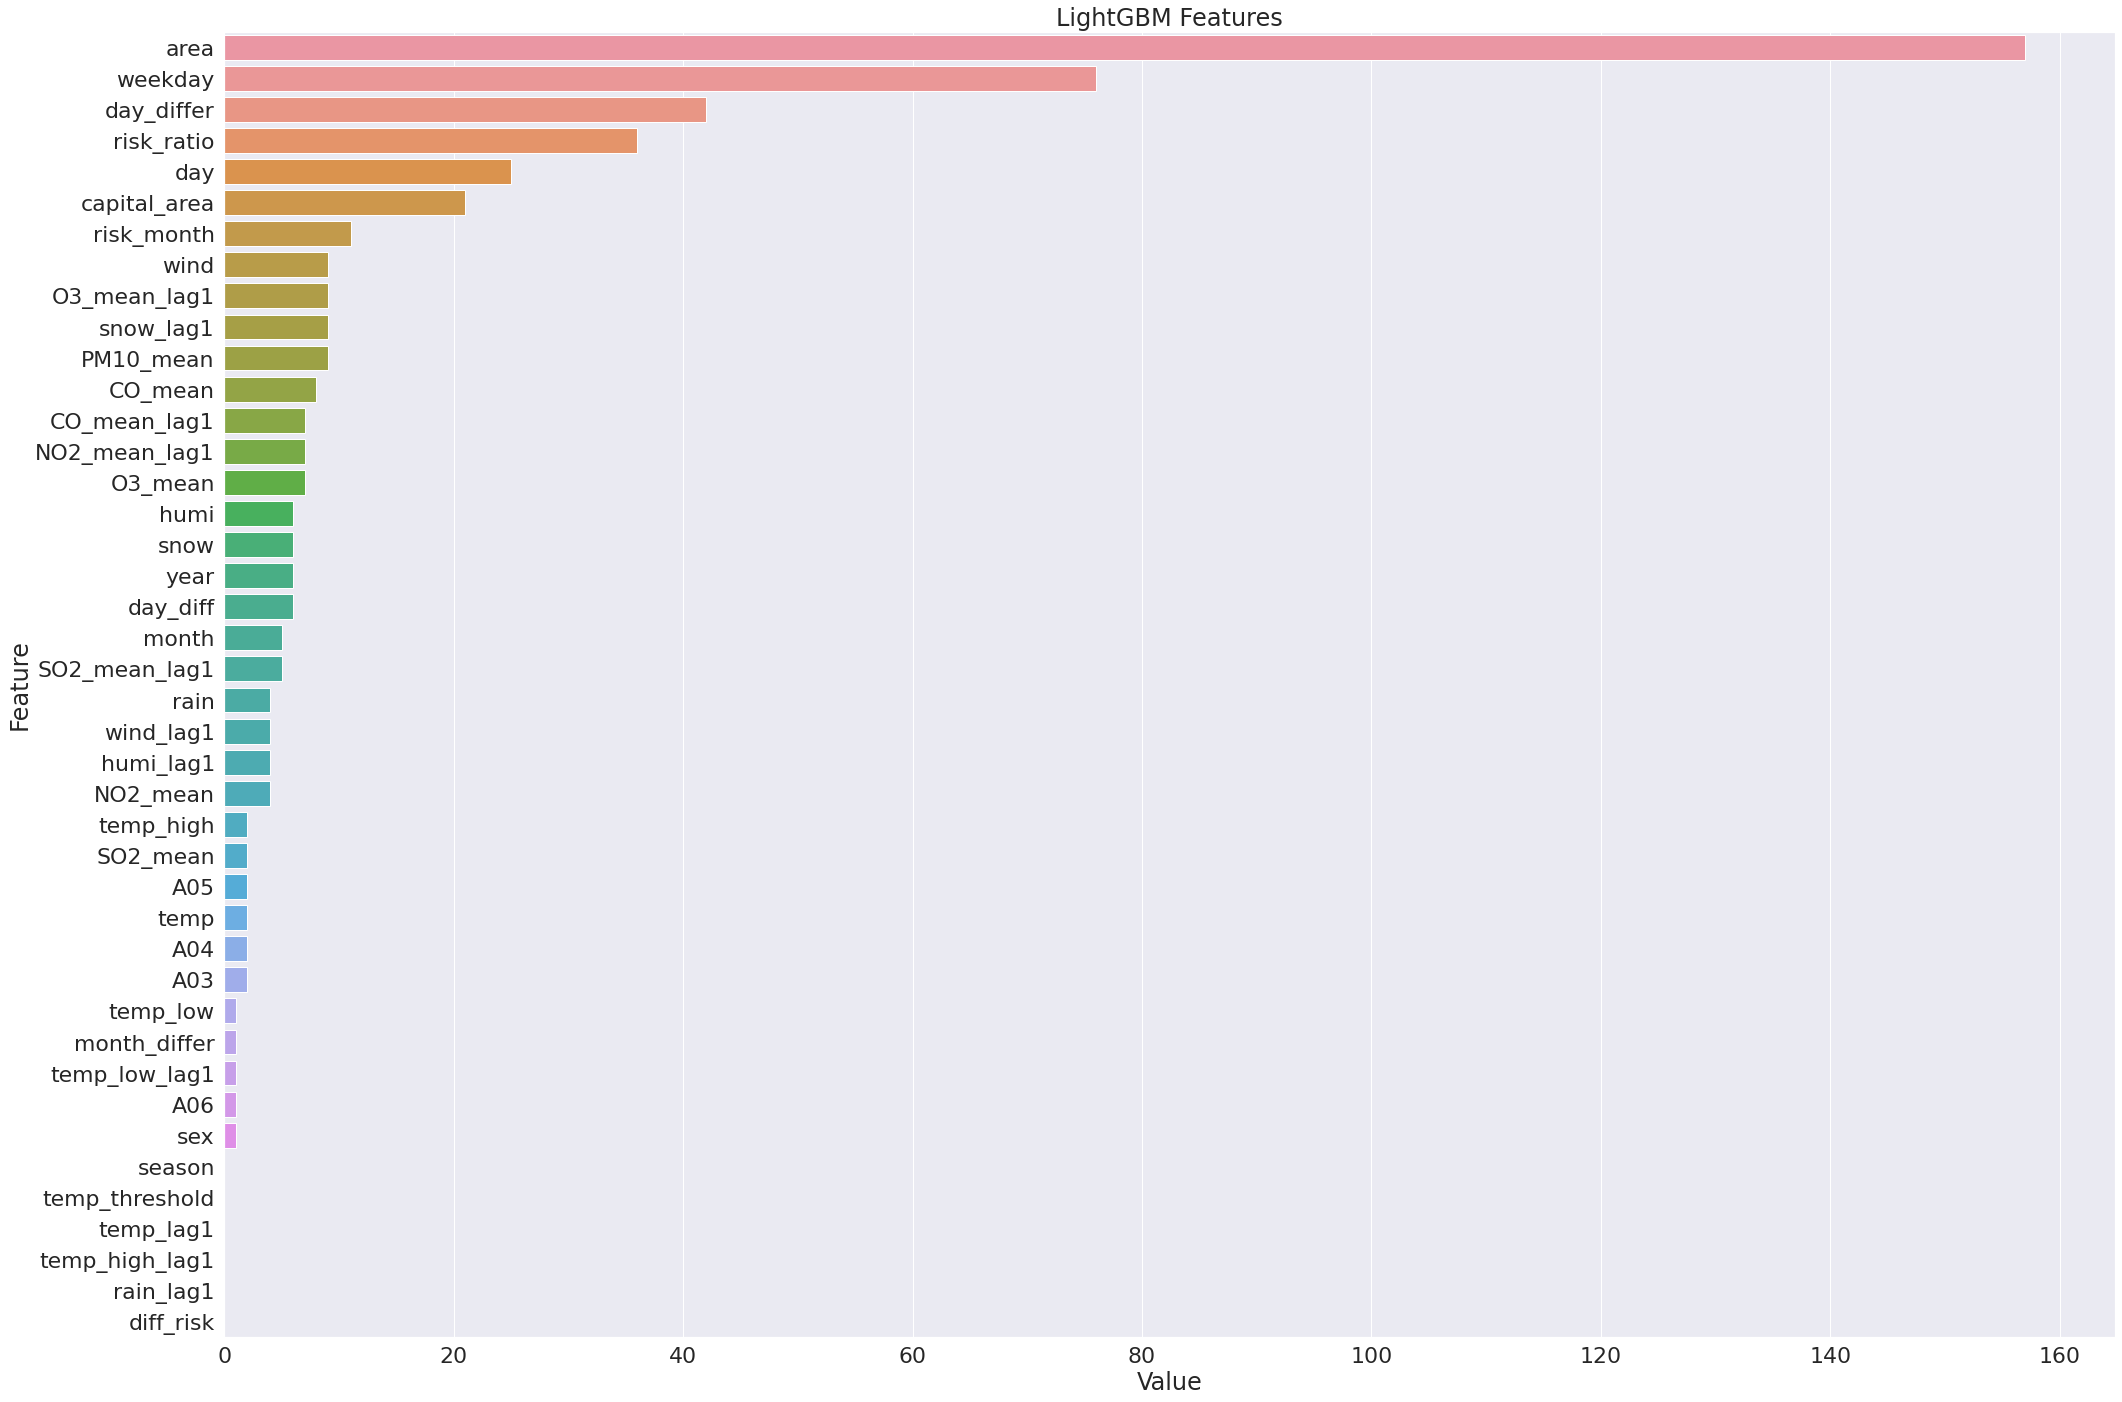

In [72]:
def plotImp(model, X , num = 100, fig_size = (30, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features')
    plt.tight_layout()
    plt.show()
LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1)
LGBM.fit(X, y, categorical_feature = ['area'], verbose=False)
plotImp(LGBM, X)

In [ ]:
# 학습함수 정의 
def objective(trial: Trial):
    param = {
        'num_leaves' : trial.suggest_int('num_leaves', 2, 12),
        'subsample' : trial.suggest_float('subsample', 0.8, 1.0, step=0.1),
        'min_child_samples' : trial.suggest_int('min_child_samples', 2, 100, 2),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 20, 400, 2),
        'max_bin' : trial.suggest_int('max_bin', 50, 300, 10),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0, 1.5, step = 0.1),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0, 1.5, step = 0.1)
    }
    cv_accuracy = []
    cv = KFold(n_splits = 5, shuffle=True, random_state=42)
    n_iter = 0

    for t,v in cv.split(train, train['frequency']):
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']

        model = LGBMRegressor(**param, random_seed=42, verbose=-1, metric = 'rmse', n_jobs=-1, n_estimators=3000)

        model.fit(X, y, eval_set=[(val_X,val_y)], categorical_feature = ['area'], verbose=False, early_stopping_rounds=50)
        score = RMSE(val_y, model.predict(val_X))

        cv_accuracy.append(score)
        n_iter += 1

    return np.mean(cv_accuracy)

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='LGBMRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=100)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
# 예측치 생성 및 제출
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

# 원래 모델 예측치 생성
LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.05)
LGBM.fit(X, y, categorical_feature = ['area'], verbose=0)
LGBM_pred = LGBM.predict(test)
submit['frequency'] = LGBM_pred * rate

# 경기, 경남, 경북, 서울 지역 제외 데이터 학습 및 예측
def fitting(data):
    train = data[data['year'] != 2016].drop('yyyymmdd', axis=1)
    test = data[data['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

    X = train.drop('frequency', axis=1)
    y = train['frequency']

    LGBM = LGBMRegressor(**study.best_trial.params, random_state=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.05)
    LGBM.fit(X, y, categorical_feature = ['area'], verbose=False)
    pred = LGBM.predict(test) * rate

    return pred
pred_1 = fitting(data_1)

# 경기, 경남, 경북, 서울 이외 지역 예측치 덮어쓰기
idx = submit[submit['area'].isin(['경기', '경남', '경북', '서울']) == False].index
submit.loc[idx, 'frequency'] = pred_1

LGBM_predict = submit['frequency'].copy()
#submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['area']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(learning_rate=0.05, max_bin=38, metric='rmse',
              min_child_samples=96, min_data_in_leaf=68, num_leaves=6,
              random_state=42, reg_alpha=0.75, reg_lambda=0.2, verbose=-1)

In [ ]:
# 최종 예측치 생성 ==> 그냥 full로 예측하고 끝내는 거랑 이거랑 비교해서 제출(stacking이 아닌 단순 집계로 앙상블 할 경우의 얘기)
LGBM = LGBMRegressor(**study.best_trial.params, objective = 'regression', metric='rmse', n_jobs=-1, n_estimators=3000, random_state=42, learning_rate=0.03)
# param = {'num_leaves': 8, 'subsample': 0.8999999999999999, 'min_child_samples': 66, 'min_data_in_leaf': 26, 'max_bin': 70, 'reg_alpha': 0.9, 'reg_lambda': 1.5}
def kfold_predict(model, train, test, num):
    preds = np.zeros(test.shape[0])
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0
    rmse = []

    for t,v in cv.split(train, train['frequency']):#, groups=train['month']
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']
    
        model.fit(X, y, eval_set=(val_X, val_y), categorical_feature = ['area'], early_stopping_rounds=50, verbose=2)
        
        preds += model.predict(test) / cv.n_splits

        rmse.append(RMSE(val_y, model.predict(val_X)))
        print(f'fold: {n_iter+1} ======> rmse : {rmse[n_iter]}')
        n_iter += 1
    print(f'total_mean ======> rmse : {np.mean(rmse)}')
    
    return preds
LGBM_predict = kfold_predict(LGBM, train, test, 10)

## 3) XGB

In [ ]:
final = dff.copy()

# 새로운 변수 생성 
final['temp'] = final[['3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21']].mean(axis=1)
final['humi'] = final[['습도_mean_9', '습도_mean_15', '습도_mean_21']].mean(axis=1)
final['temp_high'] = final[['일최고기온_mean_9', '일최고기온_mean_15', '일최고기온_mean_21']].max(axis=1)
final['temp_low'] = final[['일최저기온_mean_9', '일최저기온_mean_15', '일최저기온_mean_21']].min(axis=1)
final['wind'] = final[['풍속_mean_9','풍속_mean_15', '풍속_mean_21']].mean(axis=1)
final['rain'] = final[['강수량_mean_9','강수량_mean_15', '강수량_mean_21']].mean(axis=1)
final['snow'] = final[['적설_mean_9', '적설_mean_15', '적설_mean_21']].mean(axis=1)

dates = pd.to_datetime(final['yyyymmdd'], format='%Y%m%d').dt      
final['weekday']= dates.weekday                                     # 요일 
final['risk_ratio'] = final['num_risk_age'] / final['tot_person']   # 위험인구 비율 
final['day_diff'] = final['일최고기온_mean_15'] - final['일최저기온_mean_9']     # 일교차 
#final['temp_humi'] = final['humi'] * final['temp_low']   # 습도 * 기온
# https://www.karger.com/Article/Fulltext/505122

final['temp_threshold'] = np.where((final['일최저기온_mean_9'] < -1.5), 1, 0)  # 뇌졸중 영향 온도 threshhold
# https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0094070
conditionlist = [    
    (final['month'].isin([3,4,5])),
    (final['month'].isin([6,7,8])),
    (final['month'].isin([9,10,11])),
    (final['month'].isin([12,1,2]))]
choicelist = [1,2,3,4]
final['season'] = np.select(conditionlist, choicelist, default='Not Specified').astype('int64')  # 계절 
final['diff_risk'] = np.where(final['day_diff'] >= 10, 1, 0)                     # 일교차 10도 이상 

# 월 평균 환자 수 의 평균값보다 많은면 risk_month = 1 ,아니면 risk_month = 0
final_cpy = final.copy()
final_cpy = final_cpy.groupby(['month'])[final_cpy.columns].mean()
mean_sick = final_cpy['frequency'].mean()
for year in range(2012,2016+1):
  for month in range(1,12+1):
    if (final.loc[(final['year']==year) & (final['month']==month),'frequency'].mean()) >= mean_sick:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 1
    else:
      final.loc[(final['year']==year) & (final['month']==month),'risk_month'] = 0
del final_cpy

final['capital_area'] = np.where((final['area'].isin(['서울', '경기'])), 1, 0)  # 서울, 경기 여부 
'''
final['wind_ta_1'] = final['max_ws_mean'] * final['max_ta_max']
final['wind_ta_2'] = final['max_ws_max'] * final['min_ta_max']   # 풍속 * 온도 

final['A03'] = (final['A03_t1_mean'] + final['A03_t2_mean'] + final['A03_t3_mean']) / 3
final['A04'] = (final['A04_t1_mean'] + final['A04_t2_mean'] + final['A04_t3_mean']) / 3
final['A05'] = (final['A05_t1_mean'] + final['A05_t2_mean'] + final['A05_t3_mean']) / 3
final['A06'] = (final['A06_t1_mean'] + final['A06_t2_mean'] + final['A06_t3_mean']) / 3
'''

# 지연효과 반영 
def add_lag_feature(dat, lag = None):
    
    cols = ['temp', 'temp_high', 'temp_low','humi', 'wind', 'rain', 'snow', 'PM10_mean'] 
    '''
    'SO2_mean', 'CO_mean', 'O3_mean', 'NO2_mean', 'PM10_mean',
    'A03_t1_mean', 'A03_t1_max', 'A03_t2_mean', 'A03_t2_max', 'A03_t3_mean', 'A03_t3_max',
    'A04_t1_mean', 'A04_t1_max', 'A04_t2_mean','A04_t2_max', 'A04_t3_mean', 'A04_t3_max', 
    'A05_t1_mean', 'A05_t1_max','A05_t2_mean', 'A05_t2_max', 'A05_t3_mean', 'A05_t3_max', 
    'A06_t1_mean','A06_t1_max', 'A06_t2_mean', 'A06_t2_max', 'A06_t3_mean', 'A06_t3_max',
    'A07_t2_mean', 'A07_t2_max', 
    '''
    group_df = dat.groupby(['area'])
    lag_mean = group_df[cols].rolling(window = lag, closed='left').mean().reset_index(0,drop=True)
    for col in cols:
        dat[f'{col}_lag{lag}'] = lag_mean[col]
    return dat

add_lag_feature(final, 3)

# 2012년 초 결측치 보간 
'''
lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, verbose=0, imputation_order='roman',random_state=42)
df1 = final.drop(final.columns[0:11], axis=1)
df2 = final[final.columns[0:11]]
X = pd.DataFrame(imp.fit_transform(df1), columns = final.columns[11:])
final = pd.concat([df2, X], axis=1)
'''
# area 변수 라벨 인코딩 
cat_features = ['area']
for i in enumerate(cat_features):
    ca = i[1]
    encoder = LabelEncoder()
    encoder.fit(final[ca])
    final[ca] = encoder.transform(final[ca])

final = final.drop(['num_risk_age', 
                     'SO2_mean',
                    # 'CO_mean', 
                    # 'O3_mean', 
                    # 'NO2_mean',
                    # 'PM10_mean', 
                     
                     'A03_t1_max', 'A03_t2_max', 'A03_t3_max',
                     #'A03_t1_mean', 'A03_t2_mean', 'A03_t3_mean',
                     'A04_t1_max' ,'A04_t2_max','A04_t3_max',
                     #'A04_t1_mean', 'A04_t2_mean', 'A04_t3_mean',

                     'A05_t1_max','A05_t2_max','A05_t3_max',
                     'A06_t1_max', 'A06_t2_max', 'A06_t3_max',
                     'A07_t2_max',

                     #'A05_t1_mean', 'A05_t2_mean','A05_t3_mean',
                     #'A06_t1_mean', 'A06_t2_mean', 'A06_t3_mean',
                     'A07_t2_mean',
                    
                    '3시간기온_mean_9', '3시간기온_mean_15', '3시간기온_mean_21',
                    '습도_mean_9', '습도_mean_15', '습도_mean_21', 
                    '일최고기온_mean_9','일최고기온_mean_15', '일최고기온_mean_21', 
                    '일최저기온_mean_9','일최저기온_mean_15', '일최저기온_mean_21', 
                    '풍속_mean_9','풍속_mean_15', '풍속_mean_21', 
                    '강수량_mean_9','강수량_mean_15', '강수량_mean_21', 
                    '적설_mean_9', '적설_mean_15', '적설_mean_21',

                   # 'weekday','risk_ratio', 'day_diff', 'temp_threshold', 'season', 'diff_risk', 'risk_month', 'capital_area'
                    ], axis=1)

# 경기, 경남, 경북, 서울 지역 제외 데이터 생성 
idx = final[final['area'].isin([1,2,3,8])].index
data_1 = final.drop(idx)

# train, test split
train = final[final['year'] != 2016].drop('yyyymmdd', axis=1)
test = final[final['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

X = train.drop('frequency', axis=1)
y = train['frequency']
X.columns

# # 따로따로 모델 용 
# X = data_1.drop('frequency', axis=1)
# y = data_1['frequency']
# X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42, stratify=X['month'])
# LGBM = LGBMRegressor(**study.best_trial.params, random_seed=42, verbose=-1, metric = 'rmse', n_jobs=-1, learning_rate=0.05)
# LGBM.fit(X, y, categorical_feature = ['area'], verbose=1)

In [ ]:
# 학습함수 정의 
def objective(trial: Trial):
    param = {
        'max_depth' : trial.suggest_int('max_depth', 2, 12),
        'max_leaves' : trial.suggest_int('max_leaves', 200, 1000, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'lambda': trial.suggest_float("lambda", 0, 1, step=0.05),
        'alpha': trial.suggest_float('alpha', 0, 1, step=0.05),
        'gamma' : trial.suggest_float('gamma', 0, 1, step=0.05),
        "boosting_type": trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200),
        "max_bin": trial.suggest_int("max_bin", 600, 1200),
    } 
    model = XGBRegressor(**param, random_seed=42, objective = 'reg:squarederror', eval_metric = 'rmse', verbose=-1, 
                         metric = 'rmse', n_jobs=-1, tree_method='gpu_hist', subsample=0.9, learning_rate = 0.1)
    model.fit(X_train, y_train, eval_set=[(X_val,y_val)], verbose=False, early_stopping_rounds=50)
    rmse = RMSE(y_val, model.predict(X_val))

    return rmse

# create study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.HyperbandPruner(),
    study_name='XGBRegressor-Hyperparameter-Tuning'
)

# 학습 
study.optimize(lambda trial: objective(trial), n_trials=500)
print('Best trial : score {}, \nparams {}'.format(study.best_trial.value, study.best_trial.params))

[I 2022-08-01 15:23:53,710] A new study created in memory with name: XGBRegressor-Hyperparameter-Tuning
[I 2022-08-01 15:23:54,410] Trial 0 finished with value: 1.1964616095317675 and parameters: {'max_depth': 6, 'max_leaves': 970, 'min_child_weight': 4, 'lambda': 0.6000000000000001, 'alpha': 0.15000000000000002, 'gamma': 0.15000000000000002, 'boosting_type': 'dart', 'subsample_freq': 7, 'min_child_samples': 156, 'max_bin': 612}. Best is trial 0 with value: 1.1964616095317675.
[I 2022-08-01 15:23:59,354] Trial 1 finished with value: 1.2324580261871456 and parameters: {'max_depth': 12, 'max_leaves': 870, 'min_child_weight': 2, 'lambda': 0.15000000000000002, 'alpha': 0.15000000000000002, 'gamma': 0.30000000000000004, 'boosting_type': 'gbdt', 'subsample_freq': 3, 'min_child_samples': 142, 'max_bin': 683}. Best is trial 0 with value: 1.1964616095317675.
[I 2022-08-01 15:23:59,850] Trial 2 finished with value: 1.1937446478974112 and parameters: {'max_depth': 5, 'max_leaves': 490, 'min_child

Best trial : score 1.1896576577839482, 
params {'max_depth': 4, 'max_leaves': 650, 'min_child_weight': 4, 'lambda': 0.0, 'alpha': 0.8, 'gamma': 0.2, 'boosting_type': 'dart', 'subsample_freq': 3, 'min_child_samples': 172, 'max_bin': 959}


In [ ]:
# 예측치 생성 및 제출
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

# 원래 모델 예측치 생성
XGB = XGBRegressor(**study.best_trial.params, random_seed=42, objective = 'reg:squarederror', eval_metric = 'rmse', verbose=-1, 
                         metric = 'rmse', n_jobs=-1, tree_method='gpu_hist', subsample=0.9, learning_rate=0.05)
XGB.fit(X, y, verbose=False)
XGB_pred = XGB.predict(test)
submit['frequency'] = XGB_pred * rate

# 경기, 경남, 경북, 서울 지역 제외 데이터 학습 및 예측
def fitting(data):
    train = data[data['year'] != 2016].drop('yyyymmdd', axis=1)
    test = data[data['year'] == 2016].drop(['frequency', 'yyyymmdd'], axis=1)

    X = train.drop('frequency', axis=1)
    y = train['frequency']

    XGB = XGBRegressor(**study.best_trial.params, random_seed=42, objective = 'reg:squarederror', eval_metric = 'rmse', verbose=-1, 
                         metric = 'rmse', n_jobs=-1, tree_method='gpu_hist', subsample=0.9,learning_rate=0.05)
    XGB.fit(X, y, verbose=False)
    pred = XGB.predict(test) * rate

    return pred
pred_1 = fitting(data_1)

# 경기, 경남, 경북, 서울 이외 지역 예측치 덮어쓰기
idx = submit[submit['area'].isin(['경기', '경남', '경북', '서울']) == False].index
submit.loc[idx, 'frequency'] = pred_1

XGB_predict = submit['frequency']
#submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

In [ ]:
# 최종 예측치 생성 ==> 그냥 full로 예측하고 끝내는 거랑 이거랑 비교해서 제출(stacking이 아닌 단순 집계로 앙상블 할 경우의 얘기)
XGB = XGBRegressor(**study.best_trial.params, random_seed=42, objective = 'reg:squarederror', eval_metric = 'rmse', verbose=-1, 
                         metric = 'rmse', n_jobs=-1, tree_method='gpu_hist', subsample=0.9, max_depth = 4, learning_rate=0.05)

def kfold_predict(model, train, test, num):
    preds = np.zeros(test.shape[0])
    cv = KFold(n_splits = num, shuffle=True, random_state=42)
    n_iter = 0
    rmse = []

    for t,v in cv.split(train, train['frequency']):#, groups=train['month']
        train_cv = train.iloc[t]
        val_cv = train.iloc[v]

        X = train_cv.drop('frequency', axis=1)
        y = train_cv['frequency']

        val_X = val_cv.drop('frequency', axis=1)
        val_y = val_cv['frequency']
    
        model.fit(X, y, eval_set=[(X,y),(val_X, val_y)], verbose=False, early_stopping_rounds=50)
        
        preds += model.predict(test) / cv.n_splits

        rmse.append(RMSE(val_y, model.predict(val_X)))
        print(f'fold: {n_iter+1} ======> rmse : {rmse[n_iter]}')
        n_iter += 1
    print(f'total_mean ======> rmse : {np.mean(rmse)}')
    
    return preds
XGB_predict = kfold_predict(XGB, train, test, 10)

fold: 1 ======> rmse : 1.219448682395888
fold: 2 ======> rmse : 1.210396534172746
fold: 3 ======> rmse : 1.200299933827105
fold: 4 ======> rmse : 1.2293361142719086
fold: 5 ======> rmse : 1.2149979605371413
fold: 6 ======> rmse : 1.228651373056128
fold: 7 ======> rmse : 1.2109035933548973
fold: 8 ======> rmse : 1.193594533542
fold: 9 ======> rmse : 1.210645117309682
fold: 10 ======> rmse : 1.1979230109697763
total_mean ======> rmse : 1.211619685343727


In [ ]:
XGB = XGBRegressor(**study.best_trial.params, random_seed=42, eta=0.05)
XGB.fit(X, y, verbose=False)
XGB_preds = XGB.predict(test)

year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

submit['frequency'] = XGB_preds * rate
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

## 4) Voting

### 1. Soft Voting

In [ ]:
# https://hyemin-kim.github.io/2020/08/04/S-Python-sklearn4/#%ED%9A%8C%EA%B7%80-regression
from sklearn.ensemble import VotingRegressor

# voting 참여 single models 정의
single_models = [
                 ('LGBMRegressor', LGBM),
                 ('XGBRegressor', XGB),
                 ('CatBoostRegressor', CAT),
             #    ('GradientBoostRegressor', GB)
                ]

# voting regressor 만들기
voting_regressor = VotingRegressor(single_models, n_jobs=-1)
voting_regressor.fit(X,y)

# 증감 비율 구하기 
year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

# predcit & submission
voting_pred = voting_regressor.predict(test).tolist()
final_preds = [i * rate for i in voting_pred]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/ML_projects/weather/2-2_검증데이터셋.csv', encoding='cp949')
submit['frequency'] = final_preds
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

### 2. Stacking

In [ ]:
from mlxtend.regressor import StackingCVRegressor

stack = StackingCVRegressor(regressors = (LGBM, XGB, CAT),
                            meta_regressor = LGBM, cv = 10, use_features_in_secondary = True, shuffle=False)
stack.fit(np.array(X),y)
res = stack.predict(np.array(test))

year_frequency = final.groupby(['year'])['frequency'].mean()
rate = year_frequency.values[3] / year_frequency.values[2]

final_preds = [i * rate for i in res]

In [ ]:
submit['frequency'] = final_preds
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

### 3. average

In [ ]:
final_predict = (LGBM_predict * 0.6 + CAT_predict * 0.25 + XGB_predict * 0.15) * rate # 1.1868 / 1.1879 / 1.1900
submit['frequency'] = final_predict
submit
submit.to_csv('/content/drive/MyDrive/ML_projects/weather/raw_2/220139.csv', encoding='cp949', index=False)

,yyyymmdd,area,sex,frequency
0,2016-01-01,강원,1,2.403151
1,2016-01-01,경기,1,5.908414
2,2016-01-01,경남,1,3.508072
3,2016-01-01,경북,1,4.131808
4,2016-01-01,광주,1,1.299125
...,...,...,...,...
12439,2016-12-31,전남,2,1.058443
12440,2016-12-31,전북,2,0.925880
12441,2016-12-31,제주,2,0.296359
12442,2016-12-31,충남,2,0.811422


In [ ]:
submit['frequency'] = round(submit['frequency'])